In [1]:
# Libraries
import random
import numpy as np
import pandas as pd
from tabulate import tabulate
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [2]:
# global and final variables
suits = ["Spades", "Clubs", "Diamonds", "Hearts"]

STAND = 0
HIT = 1

#rewards
LOST = -1
WIN = 1
DRAW = 0

In [3]:
# card object that holds suit, card attribute (A, 1-10 or J,Q,K) and value of card
class Card:
    def __init__(self, suit, att, val):
        self.suit = suit
        self.attribute = att
        self.value = val

    def show(self):
        special_attributes = {1: "A", 11: "J", 12: "Q", 13: "K"}
        if(self.attribute in special_attributes):
            print(special_attributes[self.attribute]+ " of "+self.suit)
        else:
            print(self.attribute+ " of " + self.suit)
    
    def setValue(self, val):
        self.value = val

In [4]:
class Deck:
    def __init__(self):
        self.cards = []
        self.build ()

    def build(self):
        for suit in suits:
            for v in range(1, 14) :
                if v == 1: # if card is Ace set default value to 1
                    self.cards.append(Card(suit, v, 1))
                elif v <= 10: # if card is 2 - 10
                    self.cards.append(Card(suit, v, v))
                else: # if card is picture card
                    self.cards.append(Card(suit, v, 10))
                
    def show(self):
        for c in self.cards:
            c.show()
            
    def shuffle(self):
        for i in range(len(self.cards) - 1, 0, -1):
            r = random.randint(0, i)
            self.cards[i], self.cards[r] = self.cards[r] , self.cards[i]
            
    def drawCard(self):
        return self.cards.pop()  

In [5]:
class Player:
    def __init__(self):
        self.hand = []
        self.ace11 = False

    def sumOfCards(self):
        total = 0 
        for card in self.hand:
            total += card.value
        return total
        
    def draw(self, deck):
        tempSum = 0
        card = deck.drawCard()
        # if ace and sum is less than 10, use ace as 11
        if card.value == 1 and self.sumOfCards() < 11:
            card.setValue(11)
            self.ace11 = True
        else:
            tempSum = self.sumOfCards() + card.value
            # if sum is over 11 and has ace in hand, use ace as 1
            if tempSum > 21 and self.ace11 == True:
                for tempCard in self.hand:
                    if tempCard.value == 11:
                        tempCard.setValue(1)
                self.ace11 = False
        return self.hand.append(card)
    
    def showHand(self):
        for card in self.hand:
            card.show()

In [6]:
#stateActionValues is of the form (state, action)=>(qvalue, count)
StateActionValues = {}
def InitialiseQvalues():
    for PlayerSum in range(12, 22):
        for DealerCard in range(2, 12):
            for ace in [True, False]:
                s = (PlayerSum, DealerCard, ace)
                for a in [HIT, STAND]:
                    StateActionValues[(s, a)] = [0, 0]



In [7]:
#BLackJack Stategy Table
def DrawStrategyTable():
    dataWithAce = []
    index = 0
    for playerSum in range(20, 11, -1):
        dataWithAce.append([])
        for dealerCard in range(2,12):
            if(StateActionValues[((playerSum,dealerCard,True),HIT)][0] >= StateActionValues[((playerSum,dealerCard,True),STAND)][0]):
                dataWithAce[index].append('H')
            else:
                dataWithAce[index].append('S')
        index += 1

    dataNoAce = []
    index = 0
    for playerSum in range(20, 11, -1):
        dataNoAce.append([])
        for dealerCard in range(2,12):
            if(StateActionValues[((playerSum,dealerCard,False),HIT)][0] >= StateActionValues[((playerSum,dealerCard,False),STAND)][0]):
                dataNoAce[index].append('H')
            else:
                dataNoAce[index].append('S')
        index += 1
    # Create DataFrame object from a list of tuples
    StrategyWithAce = pd.DataFrame(dataWithAce, columns = ['2' , '3', '4' , '5', '6','7','8','9','10','A'], index=['20', '19', '18' , '17' , '16' , '15', '14', '13', '12'])
    Strategy = pd.DataFrame(dataNoAce, columns = ['2' , '3', '4' , '5', '6','7','8','9','10','A'], index=['20', '19', '18' , '17' , '16' , '15', '14', '13', '12'])
    print("With a usable Ace:")
    print(tabulate(StrategyWithAce, headers = 'keys', tablefmt = 'psql'))
    print("Without a usable Ace:")
    print(tabulate(Strategy, headers = 'keys', tablefmt = 'psql'))

In [8]:
def DrawStateValueFunction():

    player_values = list(range(12, 22))
    dealer_values = list(range(2, 12))

    # Create a meshgrid for player and dealer values
    X, Y = np.meshgrid(player_values, dealer_values)

    Z = np.zeros_like(X, dtype=float)

    # Populate Z with state-values
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            player_value = X[i, j]
            dealer_value = Y[i, j]
            state_value = StateActionValues.get(((player_value, dealer_value, True), HIT),[0])[0]   # Assuming True for usable ace
            
            # Check if the state value is numerical
            if isinstance(state_value, (int, float)):
                Z[i, j] = state_value
            else:
                print(f"Invalid state value encountered at ({player_value}, {dealer_value}): {state_value}")
                # Handle the invalid state value here, such as assigning a default value
                Z[i, j] = 0  # Assigning a default value

    # Plotting
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Create the 3D surface plot
    surf = ax.plot_surface(X, Y, Z, cmap='viridis')

    # Add labels
    ax.set_xlabel('Player Hand Value')
    ax.set_ylabel('Dealer Card Value')
    ax.set_zlabel('State-Value Function (V(s))')

    # Add a color bar which maps values to colors
    fig.colorbar(surf)

    # Show the plot
    plt.show()


In [9]:
def DrawHeatMap():
    X, Y = np.meshgrid(range(12, 22), range(2, 12))
    Z_hit = np.zeros_like(X)
    Z_stand = np.zeros_like(X)

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            player_value = X[i, j]
            dealer_value = Y[i, j]
            q_hit_list = StateActionValues.get(((player_value, dealer_value, True), HIT), [0])  # Default to [0] if key not found
            q_stand_list = StateActionValues.get(((player_value, dealer_value, True), STAND), [0])  # Default to [0] if key not found
            q_hit = q_hit_list[0]  # Get the first element of the list
            q_stand = q_stand_list[0]  # Get the first element of the list
            if max(q_hit, q_stand) - min(q_hit, q_stand) != 0:
                Z_hit[i, j] = 2 * (q_hit - min(q_hit, q_stand)) / (max(q_hit, q_stand) - min(q_hit, q_stand)) - 1
                Z_stand[i, j] = 2 * (q_stand - min(q_hit, q_stand)) / (max(q_hit, q_stand) - min(q_hit, q_stand)) - 1
            else:
                Z_hit[i, j] = 0  # Set to 0 if division by zero
                Z_stand[i, j] = 0  # Set to 0 if division by zero

    # Plotting
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot HIT action
    ax.scatter(X, Y, Z_hit, c='b', marker='o', label='HIT')

    # Plot STAND action
    ax.scatter(X, Y, Z_stand, c='r', marker='^', label='STAND')

    ax.set_xlabel('Player Hand Value')
    ax.set_ylabel('Dealer Card Value')
    ax.set_zlabel('Q-value')

    plt.legend()
    plt.show()


## Qlearning - an off-policy reinforcement learning algorithm

In [10]:
def updateQvalueFunction(QvalueToUpdate, R):
    QvalueToUpdate = tuple(QvalueToUpdate)
    StateActionValues[QvalueToUpdate][1] += 1 #increase count
    N = (StateActionValues[QvalueToUpdate][1]) #learning rate is the 1/count
    LR = 1/N
    #Q(s,a) = Q(s,a) + 1/N * (R-Q(s,a))
    StateActionValues[QvalueToUpdate][0] = StateActionValues[QvalueToUpdate][0] + LR * (R-StateActionValues[QvalueToUpdate][0])

In [11]:
def qLearningEpsilon(state,currentEpi, epsilon):
    sumOf = state[0]
    if sumOf < 12:
        return HIT
    if sumOf == 21:
        return STAND
    #choose best Q value action
    if random.random() < epsilon:
        a = random.choice([HIT, STAND])
    else:
        if StateActionValues[(state,HIT)][0] >= StateActionValues[(state,STAND)][0]:
            a = HIT
        else:
            a = STAND
    currentEpi.append((state,a))
    return a

In [12]:
# function that simulates a blackjack game using qLearning
def playBlackjackQlearn(epsilon):
    # setting up game environment
    playingCards = Deck()
    playingCards.shuffle()
    dealer = Player()
    user = Player()

    # user draws 2 cards and dealer draw a card
    user.draw(playingCards)
    user.draw(playingCards)
    dealer.draw(playingCards)

    # RL model decision
    currentEpi = []
    state = (user.sumOfCards(), dealer.sumOfCards(), user.ace11)
    while qLearningEpsilon(state, currentEpi, epsilon) != STAND:
        currentEpi.append([state, HIT])  # Append state-action pair
        user.draw(playingCards)
        state = (user.sumOfCards(), dealer.sumOfCards(), user.ace11)
        if user.sumOfCards() > 21:
            updateQvalueFunction(currentEpi[-1], LOST)  # Update Q-values
            return LOST
    currentEpi.append([state, STAND])
    # dealer policy (play till sum is more than 16)
    while dealer.sumOfCards() < 17:
        dealer.draw(playingCards)

    dealerFinalSum = dealer.sumOfCards()
    playerFinalSum = user.sumOfCards()
        
    result = 3  # game result
    if dealerFinalSum > 21:
        result = WIN
    elif dealerFinalSum == playerFinalSum:
        result = DRAW
    elif dealerFinalSum > playerFinalSum:
        result = LOST
    else:
        result = WIN
    
    if len(currentEpi) > 0:
        updateQvalueFunction(currentEpi[-1], result)  # Update Q-values
    return result


In [13]:
# Function to train SARSA with different epsilon values
def train_qlearn(epsilon):
    # Track win, draw, and loss counts
    Score = [0, 0, 0]

    # Initialize lists to track win, draw, and loss rates
    win_rates = []
    draw_rates = []
    loss_rates = []

    # Cumulative sums for win, draw, and loss rates
    cumulative_wins = 0
    cumulative_draws = 0
    cumulative_losses = 0

    # Main loop for training over episodes
    for episode in range(1, n + 1):
        result = playBlackjackQlearn(epsilon)  # Perform SARSA for the current episode

        # Update win, draw, and loss counts based on the result
        if episode > 0.9 * n:
            if result == WIN:
                Score[0] += 1
            elif result == DRAW:
                Score[1] += 1
            else:
                Score[2] += 1

        # Update cumulative sums for win, draw, and loss rates
        if result == WIN:
            cumulative_wins += 1
        elif result == DRAW:
            cumulative_draws += 1
        else:
            cumulative_losses += 1

        # Calculate win, draw, and loss rates for the current episode
        win_rate = cumulative_wins / episode
        draw_rate = cumulative_draws / episode
        loss_rate = cumulative_losses / episode

        # Append rates to respective lists
        win_rates.append(win_rate)
        draw_rates.append(draw_rate)
        loss_rates.append(loss_rate)

    # Calculate cumulative win, draw, and loss rates
    cumulative_win_rates = np.cumsum(win_rates) / np.arange(1, n + 1)
    cumulative_draw_rates = np.cumsum(draw_rates) / np.arange(1, n + 1)
    cumulative_loss_rates = np.cumsum(loss_rates) / np.arange(1, n + 1)

    # Calculate mean win, draw, and loss rates
    mWin = Score[0] / 100000
    mDraw = Score[1] / 100000
    mLose = Score[2] / 100000

    # Calculate dealer advantage
    dealerAdv = (mLose - mWin) / (mLose + mWin)
    
    return cumulative_win_rates, cumulative_draw_rates, cumulative_loss_rates

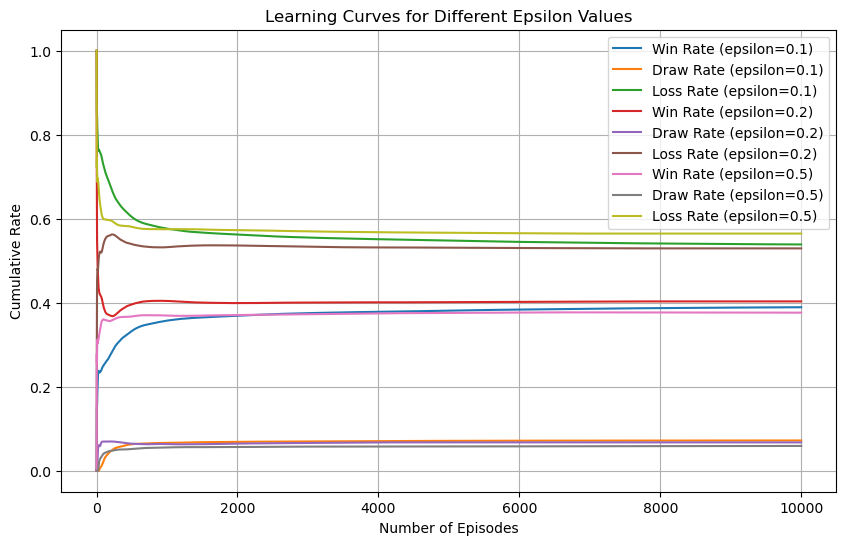

In [14]:
# Initialize Q-values
InitialiseQvalues()

# Number of episodes
n = 10000

# Epsilon values to test
epsilon_values = [0.1, 0.2, 0.5]

# Train SARSA with different epsilon values
results = {}
for epsilon in epsilon_values:
    results[epsilon] = train_qlearn(epsilon)

# Plotting
plt.figure(figsize=(10, 6))
for epsilon, (cumulative_win_rates, cumulative_draw_rates, cumulative_loss_rates) in results.items():
    plt.plot(np.arange(1, n + 1), cumulative_win_rates, label=f'Win Rate (epsilon={epsilon})')
    plt.plot(np.arange(1, n + 1), cumulative_draw_rates, label=f'Draw Rate (epsilon={epsilon})')
    plt.plot(np.arange(1, n + 1), cumulative_loss_rates, label=f'Loss Rate (epsilon={epsilon})')
plt.xlabel('Number of Episodes')
plt.ylabel('Cumulative Rate')
plt.title('Learning Curves for Different Epsilon Values')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
#Simulating game for Q learning Off-Policy
InitialiseQvalues()

n = 100000
Score = [0, 0, 0] #keep count of how many times the player wins, draws or loses
win_rates = []
draw_rates = []
loss_rates = []
for episode in range(1, n + 1):#repeat the process for n episodes
    result = playBlackjackQlearn(0.1)#Q learning Off-sarsa Policy 

    if result == WIN:
        Score[0] += 1
    elif result == DRAW:
        Score[1] += 1
    else:
        Score[2] += 1
    
    # Calculate win, draw, and loss rates for the current episode
    win_rate = Score[0] / episode
    draw_rate = Score[1] / episode
    loss_rate = Score[2] / episode

    # Append rates to respective lists
    win_rates.append(win_rate)
    draw_rates.append(draw_rate)
    loss_rates.append(loss_rate)

mWin = Score[0]/100000
mDraw = Score[1]/100000
mLose = Score[2]/100000
daelerAdv = (mLose-mWin)/(mLose+mWin)
print("mean wins",mWin)
print("mean draws",mDraw)
print("mean loses",mLose)
print("dealer advantage",daelerAdv)



mean wins 0.4128
mean draws 0.06802
mean loses 0.51918
dealer advantage 0.11414408034507176


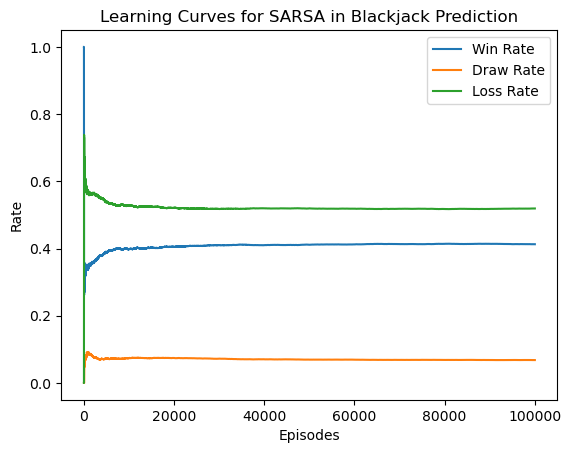

In [16]:

# Plotting the learning curves
plt.plot(range(1, n + 1), win_rates, label='Win Rate')
plt.plot(range(1, n + 1), draw_rates, label='Draw Rate')
plt.plot(range(1, n + 1), loss_rates, label='Loss Rate')

plt.xlabel('Episodes')
plt.ylabel('Rate')
plt.title('Learning Curves for SARSA in Blackjack Prediction')
plt.legend()
plt.show()

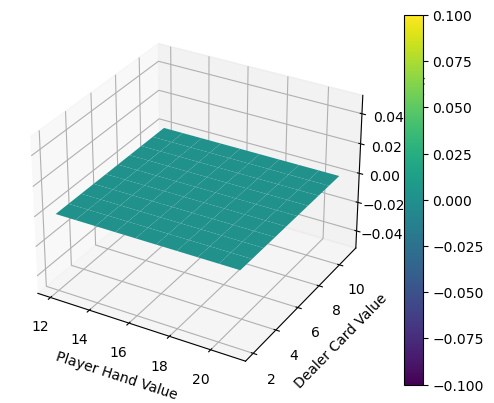

In [17]:
DrawStateValueFunction()

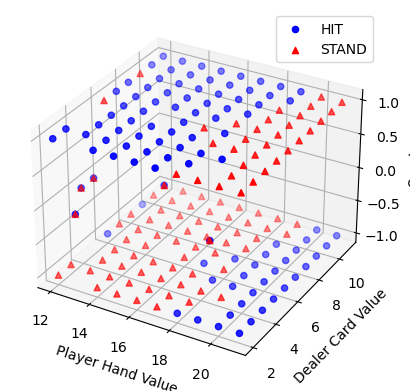

In [18]:
DrawHeatMap()

In [19]:
DrawStrategyTable()

With a usable Ace:
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
|    | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10   | A   |
|----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----|
| 20 | S   | S   | S   | S   | S   | S   | S   | S   | S    | S   |
| 19 | S   | H   | H   | S   | S   | S   | S   | S   | H    | H   |
| 18 | S   | H   | H   | S   | H   | S   | H   | H   | H    | H   |
| 17 | H   | H   | H   | H   | S   | H   | H   | H   | H    | H   |
| 16 | H   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
| 15 | H   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
| 14 | H   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
| 13 | H   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
| 12 | H   | H   | H   | H   | S   | H   | H   | S   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
Without a usable Ace:
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
|    | 

## SARSA Implementation - an on-policy learning algorithm

In [20]:
#Function for sarsa
def sarsa(state, currentEpi, exploration_rate):
    sumOf = state[0]
    if sumOf < 12:
        return HIT
    if sumOf >= 21:
        return STAND
      
    choice = [0,1] #0 means random value, 1 get best value 
    policy = random.choices(choice, weights=(exploration_rate, 1 - exploration_rate), k = 1)
    if policy == 0:
        a = random.randint(STAND, HIT)
    else:
        #choose best q value action
        if StateActionValues[(state,HIT)][0] >= StateActionValues[(state,STAND)][0]:
            a = HIT
        else:
            a = STAND
    currentEpi.append((state,a))
    return a

In [21]:
#Function to Update State-action values according to SARSA  
def sarsaUpdateValues(currQ, nextQ, R, isFinalState):
    StateActionValues[currQ][1] += 1
    N = StateActionValues[currQ][1]
    LR = 1/(N + 1)
    
    if isFinalState:#if final state there is no lookahead state we can go to
        StateActionValues[currQ][0] = StateActionValues[currQ][0] + (LR * (R - StateActionValues[currQ][0]))
    else:
        StateActionValues[currQ][0] = StateActionValues[currQ][0] + (LR * (R + StateActionValues[nextQ][0] - StateActionValues[currQ][0]))

In [22]:
# function that simulates a blackjack game using Sarsa
def playBlackjackSarsa(episode, exploration_rate_mode):
        
        # setting up game enviroment
        playingCards = Deck()
        playingCards.shuffle()
        dealer = Player()
        user = Player()

        # user draws 2 cards and dealer draw a card
        user.draw(playingCards)
        user.draw(playingCards)
        dealer.draw(playingCards)

        # Rl model decision
        currentEpi = []

        k=episode
        exploration_rate_modes = [0.1, 1/k, np.exp(-k/1000), np.exp(-k/10000)]       
        exploration_rate = exploration_rate_modes[exploration_rate_mode-1]

        state = (user.sumOfCards(),dealer.sumOfCards(),user.ace11)
        while(sarsa(state,currentEpi,exploration_rate) != STAND):
            user.draw(playingCards)
            state = (user.sumOfCards(),dealer.sumOfCards(),user.ace11)
            if user.sumOfCards() > 21:
                sarsaUpdateValues(currentEpi[-1], None, LOST, True)
                return LOST
            if len(currentEpi) == 2:#update after every step 
                sarsaUpdateValues(currentEpi[-2], currentEpi[-1], 0, False)
                currentEpi.pop(0)
        #Stand was chosen 
        
        # dealer policy (play till sum is more than 16)
        while(dealer.sumOfCards() < 17):
            dealer.draw(playingCards)

        dealerFinalSum = dealer.sumOfCards()
        playerFinalSum = user.sumOfCards()

         
        result = 3 #game result
        if dealerFinalSum > 21:
            result = WIN
        elif dealerFinalSum == playerFinalSum:
            result = DRAW
        elif dealerFinalSum > playerFinalSum:
            result = LOST
        else:
            result = WIN
        if len(currentEpi) > 0:#it might be the case that the player has 21 from the two cards dealt 
            sarsaUpdateValues(currentEpi[-1], None, result, True)
        return result

In [23]:
# Function to train SARSA with different exploration rate modes
def train_sarsa(exploration_rate_mode):
    # Track win, draw, and loss counts
    Score = [0, 0, 0]

    # Initialize lists to track win, draw, and loss rates
    win_rates = []
    draw_rates = []
    loss_rates = []

    # Cumulative sums for win, draw, and loss rates
    cumulative_wins = 0
    cumulative_draws = 0
    cumulative_losses = 0

    # Main loop for training over episodes
    for episode in range(1, n + 1):
        result = playBlackjackSarsa(episode, exploration_rate_mode)  # Perform SARSA for the current episode

        # Update win, draw, and loss counts based on the result
        if episode > 0.9 * n:
            if result == WIN:
                Score[0] += 1
            elif result == DRAW:
                Score[1] += 1
            else:
                Score[2] += 1

        # Update cumulative sums for win, draw, and loss rates
        if result == WIN:
            cumulative_wins += 1
        elif result == DRAW:
            cumulative_draws += 1
        else:
            cumulative_losses += 1

        # Calculate win, draw, and loss rates for the current episode
        win_rate = cumulative_wins / episode
        draw_rate = cumulative_draws / episode
        loss_rate = cumulative_losses / episode

        # Append rates to respective lists
        win_rates.append(win_rate)
        draw_rates.append(draw_rate)
        loss_rates.append(loss_rate)

    # Calculate cumulative win, draw, and loss rates
    cumulative_win_rates = np.cumsum(win_rates) / np.arange(1, n + 1)
    cumulative_draw_rates = np.cumsum(draw_rates) / np.arange(1, n + 1)
    cumulative_loss_rates = np.cumsum(loss_rates) / np.arange(1, n + 1)

    # Calculate mean win, draw, and loss rates
    mWin = Score[0] / 100000
    mDraw = Score[1] / 100000
    mLose = Score[2] / 100000

    # Calculate dealer advantage
    dealerAdv = (mLose - mWin) / (mLose + mWin)

    return cumulative_win_rates, cumulative_draw_rates, cumulative_loss_rates


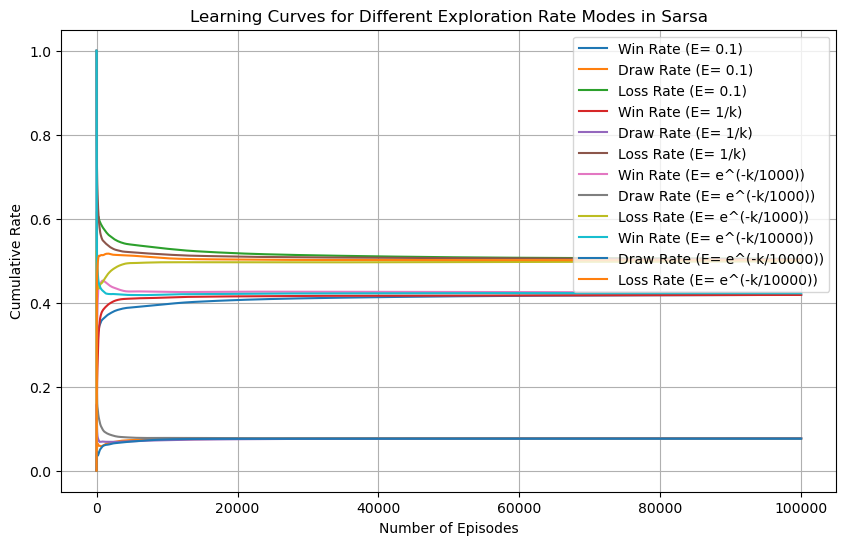

In [24]:
# Initialize Q-values
InitialiseQvalues()

# Number of episodes
n = 100000

# Exploration rate modes to test
exploration_rate_mode = [1, 2, 3, 4]
exploration_rate_modes = ["0.1", "1/k", "e^(-k/1000)", "e^(-k/10000)"]    

# Train MC with different exploration rate modes
results = {}
for e in exploration_rate_mode:
    results[e] = train_sarsa(e)

# Plotting
plt.figure(figsize=(10, 6))
for exploration_rate_mode, (cumulative_win_rates, cumulative_draw_rates, cumulative_loss_rates) in results.items():
    E = exploration_rate_modes[exploration_rate_mode-1]
    plt.plot(np.arange(1, n + 1), cumulative_win_rates, label=f'Win Rate (E= {E})')
    plt.plot(np.arange(1, n + 1), cumulative_draw_rates, label=f'Draw Rate (E= {E})')
    plt.plot(np.arange(1, n + 1), cumulative_loss_rates, label=f'Loss Rate (E= {E})')
plt.xlabel('Number of Episodes')
plt.ylabel('Cumulative Rate')
plt.title('Learning Curves for Different Exploration Rate Modes in Sarsa')
plt.legend()
plt.grid(True)
plt.show()

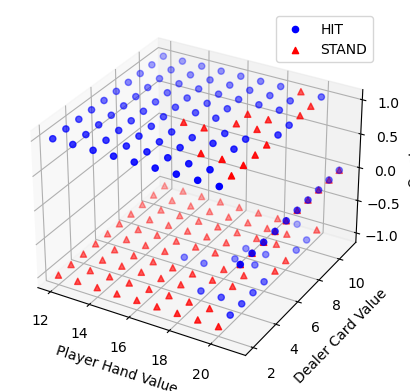

In [25]:
DrawHeatMap()

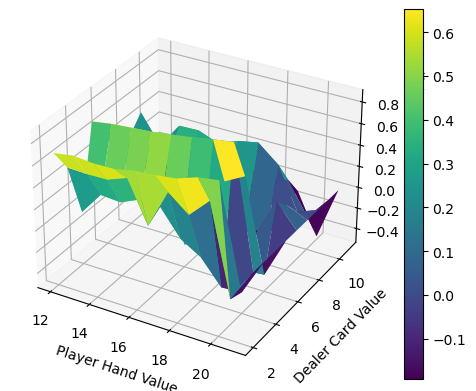

In [26]:
DrawStateValueFunction()

In [27]:
DrawStrategyTable()


With a usable Ace:
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
|    | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10   | A   |
|----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----|
| 20 | H   | S   | S   | S   | S   | H   | H   | S   | S    | H   |
| 19 | H   | H   | S   | H   | H   | S   | S   | H   | H    | S   |
| 18 | H   | H   | S   | H   | H   | S   | S   | H   | H    | H   |
| 17 | H   | H   | H   | H   | S   | H   | H   | H   | H    | H   |
| 16 | H   | H   | H   | H   | S   | H   | H   | H   | H    | H   |
| 15 | H   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
| 14 | H   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
| 13 | H   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
| 12 | H   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
Without a usable Ace:
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
|    | 

In [28]:
def updateQvalues(QvaluesToUpdate, R):
    for s in QvaluesToUpdate:
        updateQvalueFunction(s, R)

In [29]:
#function for Monte Carlo On-Policy Exploring Start
def MC(state, currentEpi, exporation_rate): #Will take 3 values 0,1,2 where 0=1/k, 1=e^-k/1000 2=e^-k/10000
    sumOf = state[0]
    if sumOf < 12:
        return HIT
    if sumOf == 21:
        return STAND

    choice = [0,1] #0 means random value, 1 get best value 
    policy = random.choices(choice, weights=(exporation_rate, 1 - exporation_rate), k = 1)
    if policy == 0:
        a = random.randint(0, 1)
    else:
        #choose best q value action
        if StateActionValues[(state,HIT)][0] >= StateActionValues[(state,STAND)][0]:
            a = HIT
        else:
            a = STAND
    currentEpi.append((state,a))
    return a

In [30]:
# function that simulates a blackjack game using MC
def playBlackjackMC(episode,exploration_rate_mode):
        
        # setting up game enviroment
        playingCards = Deck()
        playingCards.shuffle()
        dealer = Player()
        user = Player()

        # user draws 2 cards and dealer draw a card
        user.draw(playingCards)
        user.draw(playingCards)
        dealer.draw(playingCards)

        #getting exploration rate
        k=episode
        exploration_rate_modes = [0.1, 1/k, np.exp(-k/1000), np.exp(-k/10000)]       
        exploration_rate = exploration_rate_modes[exploration_rate_mode-1]

        # Rl model decision
        currentEpi = []
        state = (user.sumOfCards(),dealer.sumOfCards(),user.ace11)
        while(MC(state,currentEpi,exploration_rate) != STAND):
            user.draw(playingCards)
            state = (user.sumOfCards(),dealer.sumOfCards(),user.ace11)
            if user.sumOfCards() > 21:
                updateQvalues(currentEpi,LOST)
                return LOST
 
        while(dealer.sumOfCards() < 17):
            dealer.draw(playingCards)

        dealerFinalSum = dealer.sumOfCards()
        playerFinalSum = user.sumOfCards()

         
        result = 0 #game result
        if dealerFinalSum > 21:
            result = WIN
        elif dealerFinalSum == playerFinalSum:
            result = DRAW
        elif dealerFinalSum > playerFinalSum:
            result = LOST
        else:
            result = WIN
        updateQvalues(currentEpi,result)
        return result

In [31]:
# Function to train SARSA with different exploration rate modes
def train_mc(exploration_rate_mode):
    # Track win, draw, and loss counts
    Score = [0, 0, 0]

    # Initialize lists to track win, draw, and loss rates
    win_rates = []
    draw_rates = []
    loss_rates = []

    # Cumulative sums for win, draw, and loss rates
    cumulative_wins = 0
    cumulative_draws = 0
    cumulative_losses = 0

    # Main loop for training over episodes
    for episode in range(1, n + 1):
        result = playBlackjackMC(episode, exploration_rate_mode)  # Perform SARSA for the current episode

        # Update win, draw, and loss counts based on the result
        if episode > 0.9 * n:
            if result == WIN:
                Score[0] += 1
            elif result == DRAW:
                Score[1] += 1
            else:
                Score[2] += 1

        # Update cumulative sums for win, draw, and loss rates
        if result == WIN:
            cumulative_wins += 1
        elif result == DRAW:
            cumulative_draws += 1
        else:
            cumulative_losses += 1

        # Calculate win, draw, and loss rates for the current episode
        win_rate = cumulative_wins / episode
        draw_rate = cumulative_draws / episode
        loss_rate = cumulative_losses / episode

        # Append rates to respective lists
        win_rates.append(win_rate)
        draw_rates.append(draw_rate)
        loss_rates.append(loss_rate)

    # Calculate cumulative win, draw, and loss rates
    cumulative_win_rates = np.cumsum(win_rates) / np.arange(1, n + 1)
    cumulative_draw_rates = np.cumsum(draw_rates) / np.arange(1, n + 1)
    cumulative_loss_rates = np.cumsum(loss_rates) / np.arange(1, n + 1)

    # Calculate mean win, draw, and loss rates
    mWin = Score[0] / 100000
    mDraw = Score[1] / 100000
    mLose = Score[2] / 100000

    # Calculate dealer advantage
    dealerAdv = (mLose - mWin) / (mLose + mWin)

    return cumulative_win_rates, cumulative_draw_rates, cumulative_loss_rates


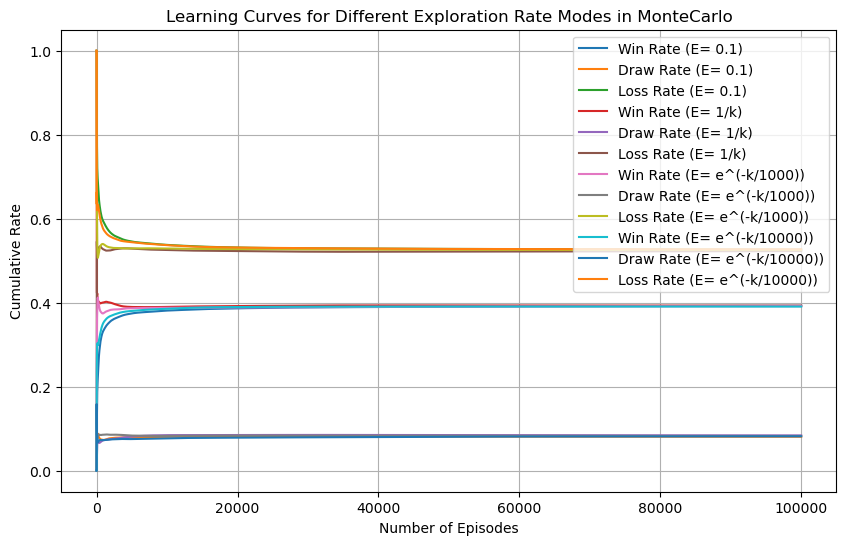

In [32]:
# Initialize Q-values
InitialiseQvalues()

# Number of episodes
n = 100000

# Exploration rate modes to test
exploration_rate_mode = [1, 2, 3, 4]
exploration_rate_modes = ["0.1", "1/k", "e^(-k/1000)", "e^(-k/10000)"]    

# Train MC with different exploration rate modes
results = {}
for e in exploration_rate_mode:
    results[e] = train_mc(e)

# Plotting
plt.figure(figsize=(10, 6))
for exploration_rate_mode, (cumulative_win_rates, cumulative_draw_rates, cumulative_loss_rates) in results.items():
    E = exploration_rate_modes[exploration_rate_mode-1]
    plt.plot(np.arange(1, n + 1), cumulative_win_rates, label=f'Win Rate (E= {E})')
    plt.plot(np.arange(1, n + 1), cumulative_draw_rates, label=f'Draw Rate (E= {E})')
    plt.plot(np.arange(1, n + 1), cumulative_loss_rates, label=f'Loss Rate (E= {E})')
plt.xlabel('Number of Episodes')
plt.ylabel('Cumulative Rate')
plt.title('Learning Curves for Different Exploration Rate Modes in MonteCarlo')
plt.legend()
plt.grid(True)
plt.show()


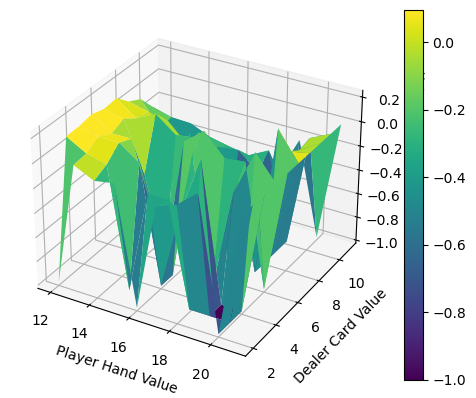

In [33]:
DrawStateValueFunction()

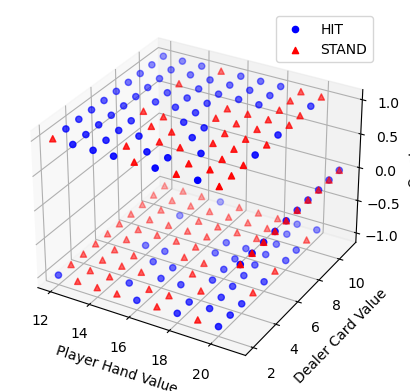

In [34]:
DrawHeatMap()

In [35]:
DrawStrategyTable()

With a usable Ace:
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
|    | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   | 10   | A   |
|----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----|
| 20 | S   | S   | S   | H   | S   | H   | S   | S   | H    | S   |
| 19 | H   | S   | S   | S   | S   | S   | S   | S   | S    | S   |
| 18 | S   | S   | H   | S   | S   | S   | S   | H   | H    | H   |
| 17 | H   | H   | S   | H   | H   | S   | S   | H   | H    | H   |
| 16 | S   | H   | S   | S   | H   | H   | H   | H   | H    | H   |
| 15 | H   | S   | H   | S   | S   | H   | H   | H   | H    | S   |
| 14 | H   | H   | H   | H   | S   | H   | H   | S   | H    | H   |
| 13 | H   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
| 12 | S   | H   | H   | H   | H   | H   | H   | H   | H    | H   |
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
Without a usable Ace:
+----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+
|    | 